# Problem 2 - Generative Adversarial Networks continue... contains part 2

In [1]:
import pandas as pd
import numpy as np
import string
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt
import time

In [2]:
# Prepare torch gpu
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
# Using GPU device
gpu_device = torch.device("cuda:0")

True
Quadro RTX 5000 with Max-Q Design


### Loading data into tensor

In [3]:
# Transform to tensors
fmnist_transform = transforms.Compose([transforms.ToTensor()])

In [4]:
# Loading the training data for use
fmnist = datasets.FashionMNIST(root="./fashion_mnist", train = True, transform = fmnist_transform, download = True)
data_loader = DataLoader(dataset = fmnist, batch_size = 64, shuffle = True, num_workers = 0)

In [5]:
# Create reverse dictionary
reverse_lookup = {x:y for y,x in data_loader.dataset.class_to_idx.items()}

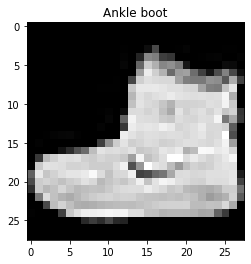

In [6]:
# Plotting the first example to see
_ = plt.imshow(data_loader.dataset.data[0], "gray")
_ = plt.title(reverse_lookup[data_loader.dataset.targets[0].detach().numpy().item()])

In [7]:
reverse_lookup

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [8]:
def show_images(torch_gpu_tensors):
    fig = plt.figure(figsize=(14,14))
    for i in range(20):
        p = i + 1
        axes = fig.add_subplot(5,4,p)
        plt.imshow(convert_d(torch_gpu_tensors, "1>2")[i].cpu().detach().numpy(), "gray")
    plt.show()

## Part 2 - GAN Loss (10 points)

In [9]:
# Convert from 2d to 1d and 1d to 2d
def convert_d(inputs, mode):
    if mode == "2>1":
        return inputs.view(inputs.size(0), 784)
    elif mode == "1>2":
        return inputs.view(inputs.size(0), 28, 28)
    else:
        return None

In [10]:
# Function to generate random noise
def random_noise(n):
    return torch.randn((n, 32))

In [11]:
# The vannila generator with 3 hidden layers and 1 output layer
class vanilla_gen(nn.Module):
    def __init__(self):
        super(vanilla_gen, self).__init__()
        # Input the noise with 64 values
        self.hidden1 = nn.Sequential(nn.Linear(32, 64), nn.ReLU())
        self.hidden2 = nn.Sequential(nn.Linear(64, 256), nn.ReLU())
        self.hidden3 = nn.Sequential(nn.Linear(256, 512), nn.ReLU())
        self.output_layer = nn.Sequential(nn.Linear(512, 784), nn.Tanh())
        
    def forward(self, x):
        out = self.hidden1(x)
        out = self.hidden2(out)
        out = self.hidden3(out)
        out = self.output_layer(out)
        return out

### MSE

In [12]:
# Generator training function
def train_gen_mse(gen_optimizer, real_data, generated_data):
    gen_optimizer.zero_grad()
    loss = mse_loss(generated_data, real_data)
    loss.backward()
    gen_optimizer.step()
    return loss

In [13]:
# The training function
def train_mse(gen_model, dataloader, gen_optimizer, num_epochs):
    # Timing
    time_start = int(round(time.time() * 1000))
    
    # Run all the epochs
    gen_img = []
    all_gen_loss = []
    gen_model.train()
    display_epoch = [1, 5, 10, 15, 20]
    for epoch in range(num_epochs):
        # Run both train and test stage in each epoch
        gen_loss = 0.0

        # Load data from dataloader
        for i, data in enumerate(data_loader, 0):
            image_data = data[0].to(gpu_device)
            real_data = Variable(convert_d(image_data, "2>1")).to(gpu_device)
            # Train Genereator
            generated_images = gen_model(random_noise(image_data.size(0)).to(gpu_device))
            g_loss = train_gen_mse(gen_optimizer, real_data, generated_images)

            # Add to loss and accuracy
            gen_loss += g_loss.item()

        epoch_gen_loss = gen_loss / dataloader.dataset.data.size(0)

        all_gen_loss.append(epoch_gen_loss)

        if (epoch + 1) in display_epoch:
            print("Epoch", str(epoch + 1), "/", str(num_epochs))
            print("Generator Loss:", epoch_gen_loss)
            gen_images = gen_model(random_noise(20).to(gpu_device))
            gen_img.append(gen_images)
            
#         # To prevent mode collapse, manually enter ok to continue
#         if (epoch + 1) in [3]:
#             gen_images = gen_model(random_noise(20).to(gpu_device))
#             show_images(gen_images)
#             input("Please press enter to continue")

        run_loss = 0.0
        run_correct = 0
        
    time_elapsed = int(round(time.time() * 1000)) - time_start
    print ('Total training time is {}ms'.format(time_elapsed))
    
    return all_gen_loss, gen_img, time_elapsed

In [14]:
# Set up models and solvers and loss for training
mse_gen_model = vanilla_gen()
mse_gen_model.to(gpu_device)

mse_loss = nn.MSELoss()
mse_gen_sgd = optim.Adam(mse_gen_model.parameters(), lr = 0.0001)

In [15]:
mse_gen_loss, mse_images, mse_time = train_mse(mse_gen_model, data_loader, mse_gen_sgd, 20)

Epoch 1 / 20
Generator Loss: 0.0014423121185352405
Epoch 5 / 20
Generator Loss: 0.0013649928944806258
Epoch 10 / 20
Generator Loss: 0.0013631911886235078
Epoch 15 / 20
Generator Loss: 0.0013626278748114903
Epoch 20 / 20
Generator Loss: 0.0013621405610193809
Total training time is 212718ms


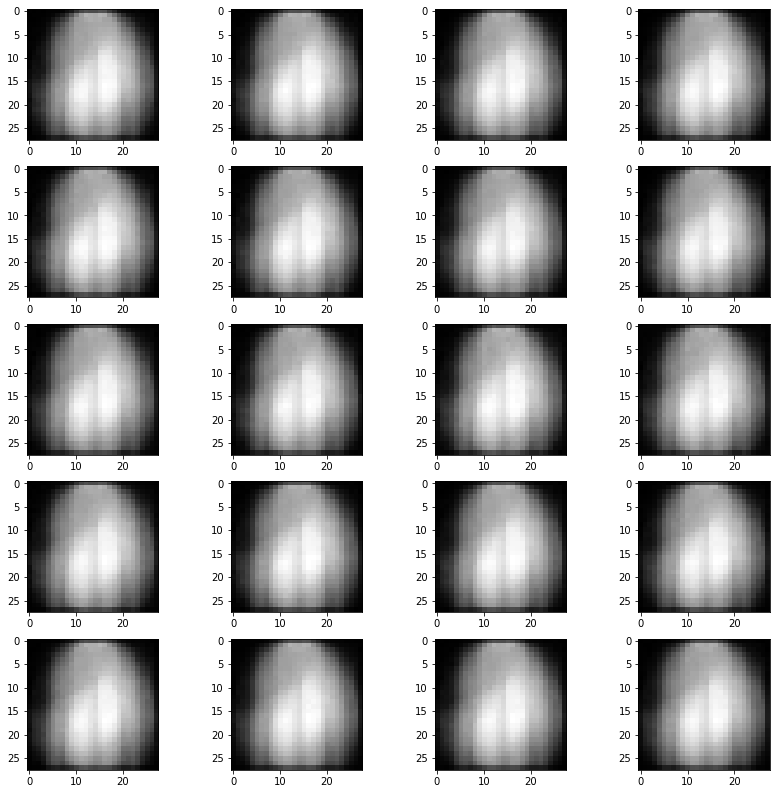

In [16]:
show_images(mse_images[-1])

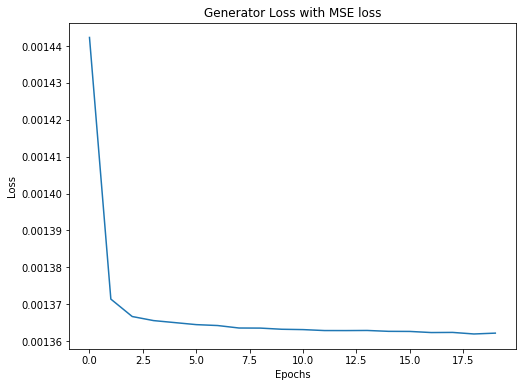

In [17]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(mse_gen_loss)), mse_gen_loss)
_ = plt.title("Generator Loss with MSE loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

### Wasserstein GAN (WGAN)

In [12]:
# The discriminator for the vannila gan
class wgan_dis(nn.Module):
    def __init__(self):
        super(wgan_dis, self).__init__()
        # Input the image with 784
        self.hidden1 = nn.Sequential(nn.Linear(784, 512), nn.ReLU())
        self.hidden2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.hidden3 = nn.Sequential(nn.Linear(256, 64), nn.ReLU())
        self.output_layer = nn.Sequential(nn.Linear(64, 1), nn.Sigmoid())
        
    def forward(self, x):
        out = self.hidden1(x)
        out = self.hidden2(out)
        out = self.hidden3(out)
        out = self.output_layer(out)
        return out

In [13]:
# Generator training function
def train_wgan_gen(gen_optimizer, generated_data):
    gen_optimizer.zero_grad()
    p = wgan_dis_model(generated_data)
    loss = wgan_loss(p, Variable(torch.ones(generated_data.size(0), 1)).to(gpu_device))
    loss.backward()
    gen_optimizer.step()
    return loss

In [14]:
# Discriminator training funciton
def train_wgan_dis(dis_optimizer, real_data, generated_data, clip_value):
    dis_optimizer.zero_grad()
    # Train with real data
    p_real = wgan_dis_model(real_data)
    loss_real = wgan_loss(p_real, Variable(torch.ones(real_data.size(0), 1)).to(gpu_device))
    loss_real.backward()
    # Train with generated data
    p_gen = wgan_dis_model(generated_data)
    loss_generated = wgan_loss(p_gen, Variable(torch.zeros(generated_data.size(0), 1)).to(gpu_device))
    loss_generated.backward()
    
    dis_optimizer.step()
    
    # Clipping between clip value
    for para in wgan_dis_model.parameters():
        para.data.clamp_(-clip_value/2, clip_value/2)
    
    return loss_real + loss_generated, p_real, p_gen

In [15]:
# The training function
def train_wgan(gen_model, dis_model, dataloader, gen_optimizer, dis_optimizer, clip_value, num_epochs):
    # Timing
    time_start = int(round(time.time() * 1000))
    
    # Run all the epochs
    gen_img = []
    all_dis_loss = []
    all_gen_loss = []
    gen_model.train()
    dis_model.train()
    display_epoch = [1, 5, 10, 15, 20]
    for epoch in range(num_epochs):
        # Run both train and test stage in each epoch
        dis_loss = 0.0
        gen_loss = 0.0

        # Load data from dataloader
        for i, data in enumerate(data_loader, 0):
            image_data = data[0].to(gpu_device)
            real_data = Variable(convert_d(image_data, "2>1")).to(gpu_device)
            # Train Discriminator
            generated_data = gen_model(random_noise(real_data.size(0)).to(gpu_device)).detach()
            d_loss, d_p_real, d_p_generated = train_wgan_dis(dis_optimizer, real_data, generated_data, clip_value)
            # Train Genereator
            generated_images = gen_model(random_noise(image_data.size(0)).to(gpu_device))
            g_loss = train_wgan_gen(gen_optimizer, generated_images)

            # Add to loss and accuracy
            dis_loss += d_loss.item()
            gen_loss += g_loss.item()

        epoch_dis_loss = dis_loss / dataloader.dataset.data.size(0)
        epoch_gen_loss = gen_loss / dataloader.dataset.data.size(0)

        all_dis_loss.append(epoch_dis_loss)
        all_gen_loss.append(epoch_gen_loss)

        if (epoch + 1) in display_epoch:
            print("Epoch", str(epoch + 1), "/", str(num_epochs))
            print("Discriminator Loss:", epoch_dis_loss)
            print("Generator Loss:", epoch_gen_loss)
            gen_images = gen_model(random_noise(20).to(gpu_device))
            gen_img.append(gen_images)
            
#         # To prevent mode collapse, manually enter ok to continue
#         if (epoch + 1) in [3]:
#             gen_images = gen_model(random_noise(20).to(gpu_device))
#             show_images(gen_images)
#             input("Please press enter to continue")

        run_loss = 0.0
        run_correct = 0
    
    time_elapsed = int(round(time.time() * 1000)) - time_start
    print ('Total training time is {}ms'.format(time_elapsed))
    return all_dis_loss, all_gen_loss, gen_img, time_elapsed

In [16]:
# Running with set {0.1; 0.01; 0.001; 0.0001}
wgan_all_model = {}
for each_clip_value in [0.1, 0.01, 0.001, 0.0001]:
    print("Clip Value:", each_clip_value)
    # Set up models and solvers and loss for training
    wgan_gen_model = vanilla_gen()
    wgan_gen_model.to(gpu_device)

    wgan_dis_model = wgan_dis()
    wgan_dis_model.to(gpu_device)

    wgan_loss = nn.BCELoss()
    wgan_gen_sgd = optim.Adam(wgan_gen_model.parameters(), lr = 0.0001)
    wgan_dis_sgd = optim.Adam(wgan_dis_model.parameters(), lr = 0.0001)
    
    wgan_dis_loss, wgan_gen_loss, wgan_gen_pic, wgan_time = train_wgan(wgan_gen_model, wgan_dis_model, data_loader, 
                                                                       wgan_gen_sgd, wgan_dis_sgd,
                                                                       clip_value = each_clip_value, num_epochs = 20)
    
    wgan_all_model[str(each_clip_value)] = [wgan_gen_model, wgan_dis_model,
                                         wgan_dis_loss, wgan_gen_loss, wgan_gen_pic, wgan_time]

Clip Value: 0.1
Epoch 1 / 20
Discriminator Loss: 0.010262710333118836
Generator Loss: 0.02230096000134945
Epoch 5 / 20
Discriminator Loss: 0.0052979822039604186
Generator Loss: 0.038548876547813415
Epoch 10 / 20
Discriminator Loss: 0.00634406584178408
Generator Loss: 0.03639728025794029
Epoch 15 / 20
Discriminator Loss: 0.006305959662546714
Generator Loss: 0.03599827578663826
Epoch 20 / 20
Discriminator Loss: 0.007199782219032447
Generator Loss: 0.035625255767504374
Total training time is 493979ms
Clip Value: 0.01
Epoch 1 / 20
Discriminator Loss: 0.02162464767098427
Generator Loss: 0.010839666166901588
Epoch 5 / 20
Discriminator Loss: 0.02167101970712344
Generator Loss: 0.010837115569909414
Epoch 10 / 20
Discriminator Loss: 0.021672401905059816
Generator Loss: 0.010836200952529908
Epoch 15 / 20
Discriminator Loss: 0.021672401905059816
Generator Loss: 0.010836200952529908
Epoch 20 / 20
Discriminator Loss: 0.021672401905059816
Generator Loss: 0.010836200952529908
Total training time is 5

#### Look at the last epoch generated outputs for all the clip size

WGAN with c = 0.1


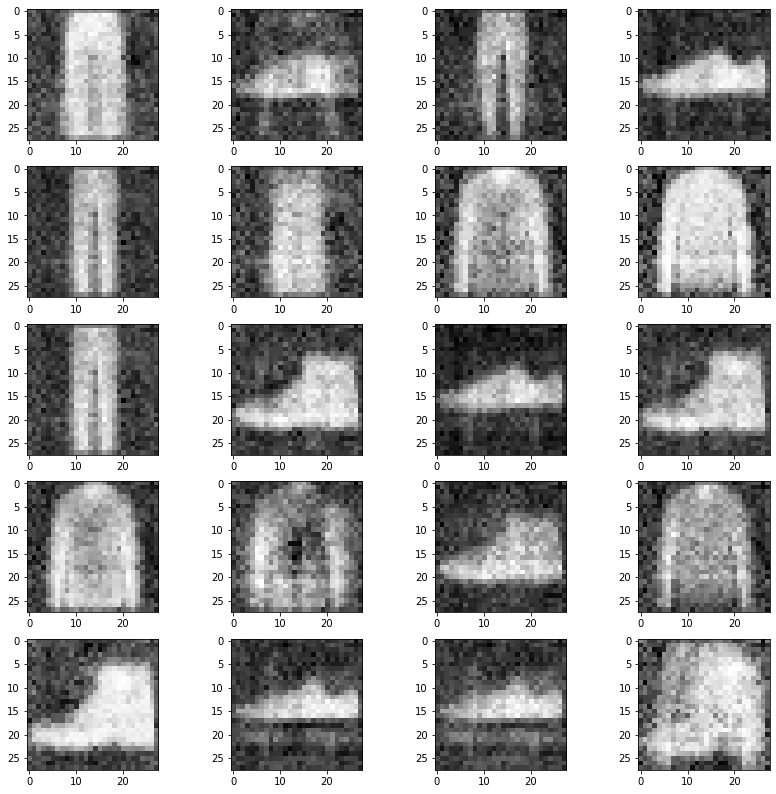

In [17]:
print("WGAN with c = 0.1")
show_images(wgan_all_model["0.1"][-2][-1])

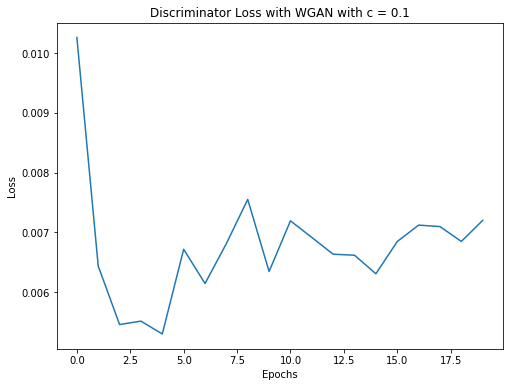

In [18]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(wgan_all_model["0.1"][2])), wgan_all_model["0.1"][2])
_ = plt.title("Discriminator Loss with WGAN with c = 0.1")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

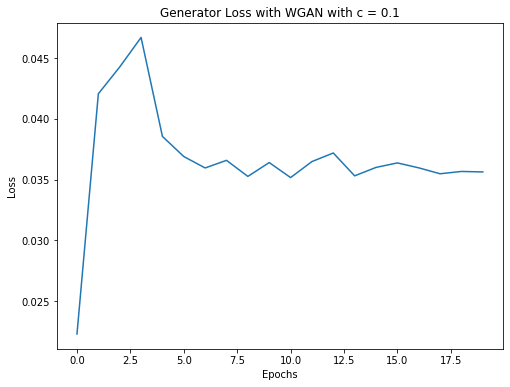

In [19]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(wgan_all_model["0.1"][3])), wgan_all_model["0.1"][3])
_ = plt.title("Generator Loss with WGAN with c = 0.1")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

WGAN with c = 0.01


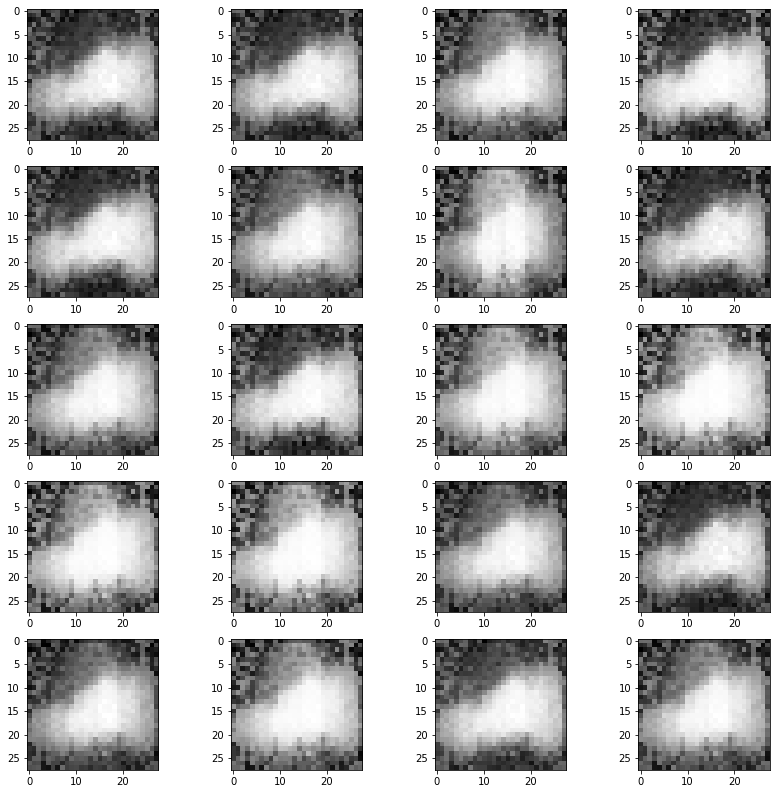

In [20]:
print("WGAN with c = 0.01")
show_images(wgan_all_model["0.01"][-2][-1])

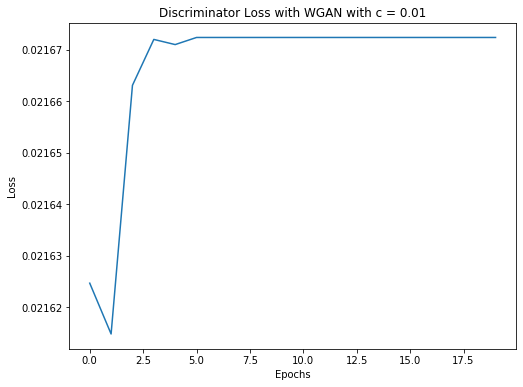

In [21]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(wgan_all_model["0.01"][2])), wgan_all_model["0.01"][2])
_ = plt.title("Discriminator Loss with WGAN with c = 0.01")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

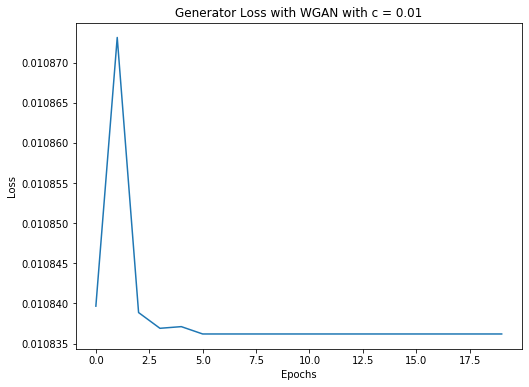

In [22]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(wgan_all_model["0.01"][3])), wgan_all_model["0.01"][3])
_ = plt.title("Generator Loss with WGAN with c = 0.01")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

WGAN with c = 0.001


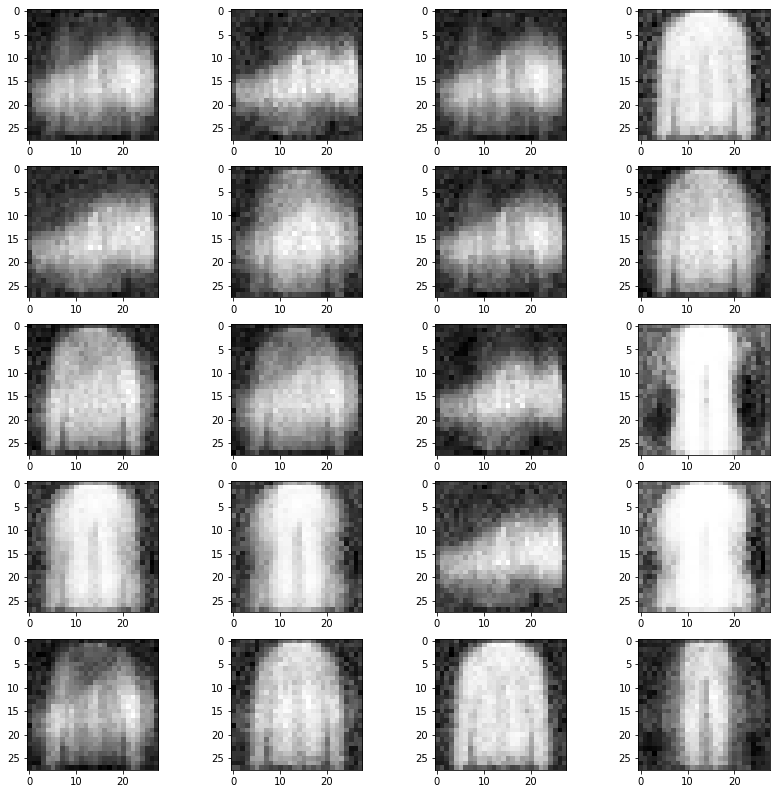

In [23]:
print("WGAN with c = 0.001")
show_images(wgan_all_model["0.001"][-2][-1])

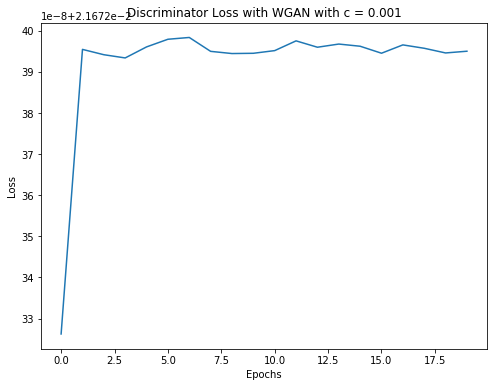

In [24]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(wgan_all_model["0.001"][2])), wgan_all_model["0.001"][2])
_ = plt.title("Discriminator Loss with WGAN with c = 0.001")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

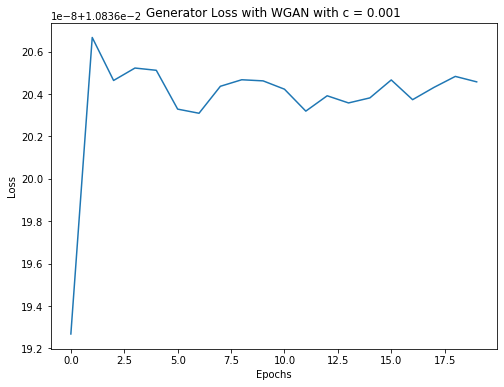

In [25]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(wgan_all_model["0.001"][3])), wgan_all_model["0.001"][3])
_ = plt.title("Generator Loss with WGAN with c = 0.001")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

WGAN with c = 0.0001


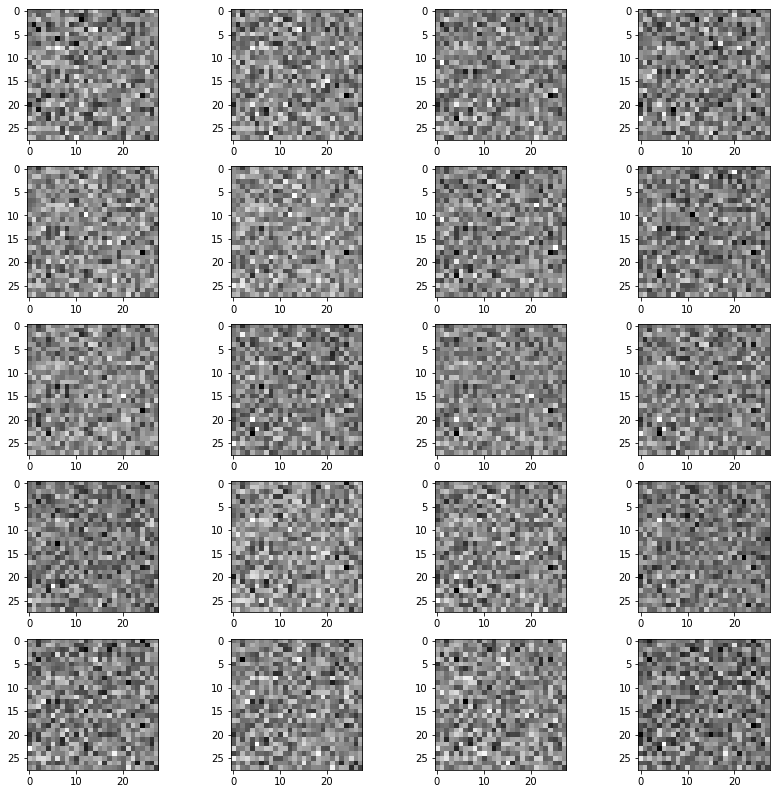

In [26]:
print("WGAN with c = 0.0001")
show_images(wgan_all_model["0.0001"][-2][-1])

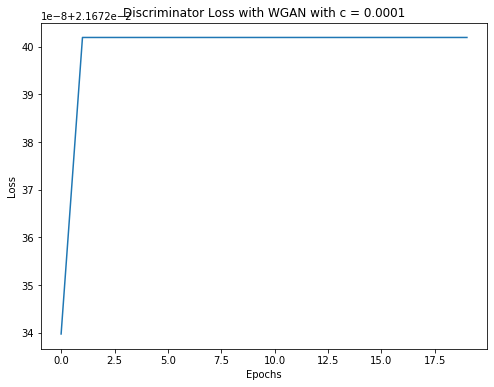

In [27]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(wgan_all_model["0.0001"][2])), wgan_all_model["0.0001"][2])
_ = plt.title("Discriminator Loss with WGAN with c = 0.0001")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

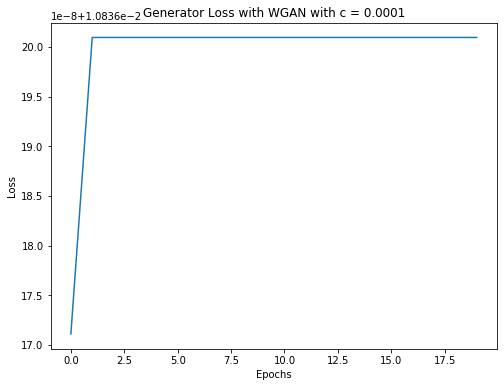

In [28]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(wgan_all_model["0.0001"][3])), wgan_all_model["0.0001"][3])
_ = plt.title("Generator Loss with WGAN with c = 0.0001")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

In [29]:
# SAVE THE BEST MODEL C = 0.1
# Save model
torch.save(wgan_all_model["0.1"][0].state_dict(), "./wgan_gen.pth")

### Least Square GAN

In [35]:
# Generator training function
def train_ls_gen(gen_optimizer, generated_data):
    gen_optimizer.zero_grad()
    p = ls_dis_model(generated_data)
    loss = ls_loss(p, Variable(torch.ones(generated_data.size(0), 1)).to(gpu_device))
    loss.backward()
    gen_optimizer.step()
    return loss

In [36]:
# The discriminator for the vannila gan
class ls_dis(nn.Module):
    def __init__(self):
        super(ls_dis, self).__init__()
        # Input the image with 784
        self.hidden1 = nn.Sequential(nn.Linear(784, 512), nn.ReLU())
        self.hidden2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.hidden3 = nn.Sequential(nn.Linear(256, 64), nn.ReLU())
        self.output_layer = nn.Sequential(nn.Linear(64, 1), nn.Sigmoid())
        
    def forward(self, x):
        out = self.hidden1(x)
        out = self.hidden2(out)
        out = self.hidden3(out)
        out = self.output_layer(out)
        return out

In [37]:
# Discriminator training funciton
def train_ls_dis(dis_optimizer, real_data, generated_data):
    dis_optimizer.zero_grad()
    # Train with real data
    p_real = ls_dis_model(real_data)
    loss_real = ls_loss(p_real, Variable(torch.ones(real_data.size(0), 1)).to(gpu_device))
    loss_real.backward()
    # Train with generated data
    p_gen = ls_dis_model(generated_data)
    loss_generated = ls_loss(p_gen, Variable(torch.zeros(generated_data.size(0), 1)).to(gpu_device))
    loss_generated.backward()
    
    dis_optimizer.step()
    
    return loss_real + loss_generated, p_real, p_gen

In [38]:
# The training function
def train_ls(gen_model, dis_model, dataloader, gen_optimizer, dis_optimizer, num_epochs):
    # Timing
    time_start = int(round(time.time() * 1000))
    
    # Run all the epochs
    gen_img = []
    all_dis_loss = []
    all_gen_loss = []
    gen_model.train()
    dis_model.train()
    display_epoch = [1, 5, 10, 15, 20]
    for epoch in range(num_epochs):
        # Run both train and test stage in each epoch
        dis_loss = 0.0
        gen_loss = 0.0

        # Load data from dataloader
        for i, data in enumerate(data_loader, 0):
            image_data = data[0].to(gpu_device)
            real_data = Variable(convert_d(image_data, "2>1")).to(gpu_device)
            # Train Discriminator
            generated_data = gen_model(random_noise(real_data.size(0)).to(gpu_device)).detach()
            d_loss, d_p_real, d_p_generated = train_ls_dis(dis_optimizer, real_data, generated_data)
            # Train Genereator
            generated_images = gen_model(random_noise(image_data.size(0)).to(gpu_device))
            g_loss = train_ls_gen(gen_optimizer, generated_images)

            # Add to loss and accuracy
            dis_loss += d_loss.item()
            gen_loss += g_loss.item()

        epoch_dis_loss = dis_loss / dataloader.dataset.data.size(0)
        epoch_gen_loss = gen_loss / dataloader.dataset.data.size(0)

        all_dis_loss.append(epoch_dis_loss)
        all_gen_loss.append(epoch_gen_loss)

        if (epoch + 1) in display_epoch:
            print("Epoch", str(epoch + 1), "/", str(num_epochs))
            print("Discriminator Loss:", epoch_dis_loss)
            print("Generator Loss:", epoch_gen_loss)
            gen_images = gen_model(random_noise(20).to(gpu_device))
            gen_img.append(gen_images)
            
        # To prevent mode collapse, manually enter ok to continue
#         if (epoch + 1) in [3]:
#             gen_images = gen_model(random_noise(20).to(gpu_device))
#             show_images(gen_images)
#             input("Please press enter to continue")

        run_loss = 0.0
        run_correct = 0
    
    time_elapsed = int(round(time.time() * 1000)) - time_start
    print ('Total training time is {}ms'.format(time_elapsed))
    return all_dis_loss, all_gen_loss, gen_img

In [39]:
# Set up models and solvers and loss for training
ls_gen_model = vanilla_gen()
ls_gen_model.to(gpu_device)

ls_dis_model = ls_dis()
ls_dis_model.to(gpu_device)

ls_loss = nn.MSELoss()
ls_gen_sgd = optim.Adam(ls_gen_model.parameters(), lr = 0.0001)
ls_dis_sgd = optim.Adam(ls_dis_model.parameters(), lr = 0.0001)

In [40]:
ls_dis_loss, ls_gen_loss, ls_gen_pic = train_ls(ls_gen_model, ls_dis_model,
                                                  data_loader, ls_gen_sgd, ls_dis_sgd, 20)

Epoch 1 / 20
Discriminator Loss: 0.0018021474530221895
Generator Loss: 0.011490943758189678
Epoch 5 / 20
Discriminator Loss: 0.0016620065529209872
Generator Loss: 0.013612720296780269
Epoch 10 / 20
Discriminator Loss: 0.0027458755807795872
Generator Loss: 0.013028767431775728
Epoch 15 / 20
Discriminator Loss: 0.00277976663193355
Generator Loss: 0.01249591080447038
Epoch 20 / 20
Discriminator Loss: 0.002985738582164049
Generator Loss: 0.012044907067219416
Total training time is 436947ms


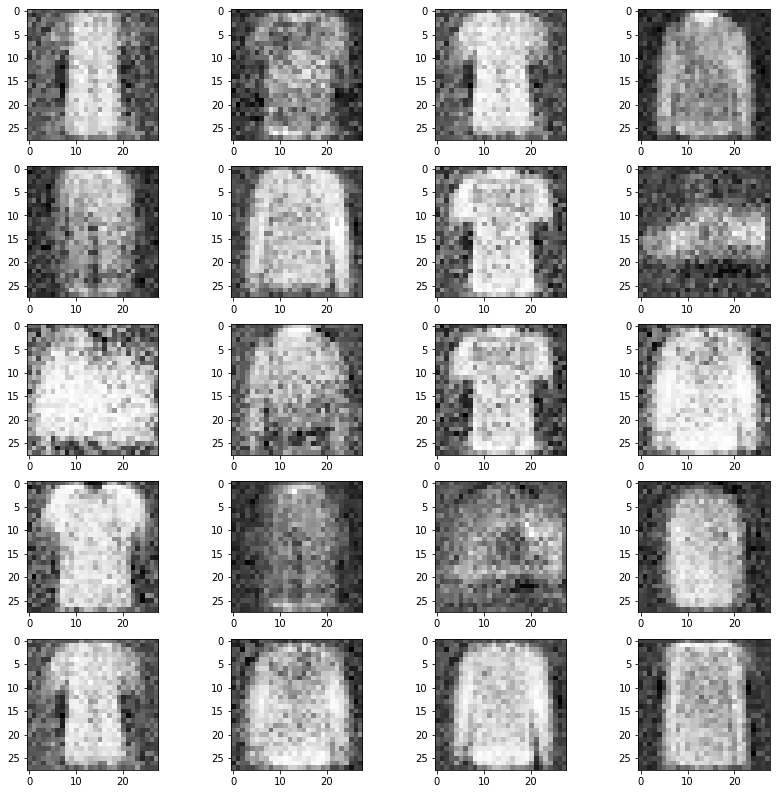

In [41]:
show_images(ls_gen_pic[-1])

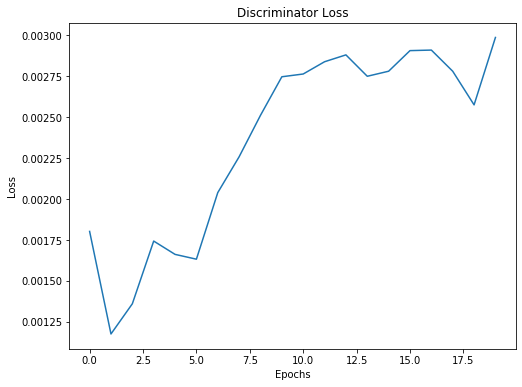

In [42]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(ls_dis_loss)), ls_dis_loss)
_ = plt.title("Discriminator Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

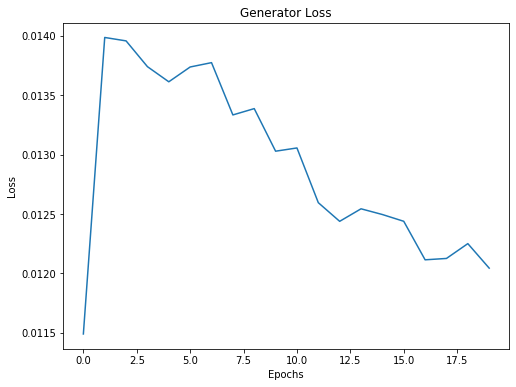

In [43]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(ls_gen_loss)), ls_gen_loss)
_ = plt.title("Generator Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")